 # **KEMGNE TAPE KILIAN LENAÏC**
 

*   CLASSE : 4GI
*   MATRICULE : 19P069


# **Resume du TP**

>L'objectif principal de ce TP est d'évaluer certains classificateurs de base dans la tâche d'analyse des sentiments. Pour résoudre ce problème, une combinaison de l'approches d'incorporation de mots TF-IDF et quatre classificateurs de base (SVM, Naive Bayes, Decision Tree, LDA) ainsi que certaines techniques de prétraitement de texte ont été essayées. sur l'ensemble de données des critiques de films IMDB.

> Ensemble de données IMDB sur les critiques de films L'ensemble de données contient 50 000 critiques, dont la moitié sont positives et l'autre moitié négatives. Cet ensemble de données a été compilé par <a href="http://ai.stanford.edu/~amaas/">Andrew Maas</a> et peut être trouvé ici : <a href="http://ai.stanford.edu/~amaas/data/sentiment/">Grand ensemble de données sur les critiques de films</a>



# **Telechargement et installation des prerequis**


> **Bibliothèques**

In [24]:
import os
import re
import numpy as np
import pandas as pd
import graphviz 
import pickle
import random

import nltk
nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from prettytable import PrettyTable


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


>  ## **Telechargement du dataset**


---

> L'ensemble de données a été divisé de manière égale en un ensemble d'apprentissage et un ensemble de test. De plus, chaque ensemble contient 12,5 000 avis positifs et 12,5 000 avis négatifs. Les données de formation et de test ont été chargées sous forme de trames de données Pandas.

In [25]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  19.5M      0  0:00:04  0:00:04 --:--:-- 19.5M


In [26]:
!ls

aclImdb  aclImdb_v1.tar.gz  df	df.pdf	sample_data


> ### **Fonction de recupération des données**

In [27]:
def loadDataset(data_dir):
    
    data = {}
    for partition in ["train", "test"]:
        data[partition] = []
        for sentiment in ["neg", "pos"]:
            lable = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, partition, sentiment)
            files = os.listdir(path)
            for f_name in files:
                with open(os.path.join(path, f_name), "rb") as f:
                    review = f.read().decode('utf-8').replace('\n', '')
                    data[partition].append([review, lable])

    random.seed(4) # to comparision purpose
    random.shuffle(data["train"])
    random.shuffle(data["test"])
    
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['review', 'sentiment'])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['review', 'sentiment'])

    return data["train"], data["test"]

> **Données D'entrainement**

In [28]:
data_dir = "aclImdb/"

train_data, test_data = loadDataset(data_dir)
print('# trainings:')
train_data


# trainings:


,review,sentiment
0,Boy what a dud this mess was.But it only lasts...,0
1,Just when you thought it was safe to go back i...,0
2,"I enjoyed this movie, granted it is mainly bec...",1
3,This film pulls you in from the get-go because...,1
4,I loved the episode but seems to me there shou...,1
...,...,...
24995,"""The House That Dripped Blood"" is one of the b...",1
24996,After erasing my thoughts nearly twenty-seven ...,1
24997,From around the time Europe began fighting Wor...,0
24998,A family moves into a old house in Japan. But ...,0


> **Données de test**

In [29]:
print('# testings:')
test_data

# testings:


,review,sentiment
0,Text Taken from 2001 Melbourne International F...,1
1,"OK, first off there may be a SPOILER here sinc...",0
2,A good old-fashioned flight-and-revenge wester...,1
3,Andaz Apna Apna is a movie that I treasure and...,1
4,Some people say this show was good in it's ear...,0
...,...,...
24995,William Petersen (that C.S.I guy) has a small ...,0
24996,I never read the book. Now I don't really want...,0
24997,I too saw this movie when it first came out. I...,1
24998,I thought this was a very daring representatio...,1


# **Prétraitement du dataSet**

> Depuis que cet ensemble de données a été extrait du Web, certains codes HTML y ont été mélangés. Il est donc nécessaire de nettoyer ces textes en supprimant les balises HTML. Supprimer les nombres, les ponctuations et les mots vides, remplacer le verbe de contraction négatif par des formes complètes comme will't, diviser les noms composés qui sont faits avec un trait d'union comme l'état de l'art, et normaliser les textes en les abaissant serait être bénéfique.

In [30]:
df_dataset = pd.concat([train_data,test_data], ignore_index=True)
print("Total reviews in df: ", df_dataset.shape)

Total reviews in df:  (50000, 2)


In [31]:
stop_words = set(stopwords.words('english'))
lemma = nltk.WordNetLemmatizer()
stop_words.remove('not')

def text_preprocessing(doc):
  

  #enlevons les caractères indésirables
  doc = re.sub(re.compile('<.*?>'), '', doc)
  doc = re.sub(re.compile('[^A-Za-z0-9]+'),' ',doc)

  #rendons toutes les lettres minuscules
  doc = doc.lower()

  #séparons le commentaire en tokens
  tokens = word_tokenize(doc)

  #enlevons les stop_words anglais du commentaire
  raw_tokens_list = [w for w in tokens if w not in stop_words]

  #lemmatization pour conserver les sens des tokens
  cleaned_tokens_list =  [lemma.lemmatize(i) for i in raw_tokens_list]

  #rassemblons les tokens
  final_tokens = ' '.join(cleaned_tokens_list)

  return final_tokens
#appliquons cette fonction à chaque review de notre dataset
df_dataset['preprocessed_tokens'] = df_dataset['review'].apply(lambda review: text_preprocessing(review))
train_data['preprocessed_tokens'] = train_data['review'].apply(lambda review: text_preprocessing(review))
test_data['preprocessed_tokens'] = test_data['review'].apply(lambda review: text_preprocessing(review))

In [32]:
df_dataset

,review,sentiment,preprocessed_tokens
0,Boy what a dud this mess was.But it only lasts...,0,boy dud mess last hour paid buck live unlike e...
1,Just when you thought it was safe to go back i...,0,thought safe go back water another computer ge...
2,"I enjoyed this movie, granted it is mainly bec...",1,enjoyed movie granted mainly enjoy seeing sean...
3,This film pulls you in from the get-go because...,1,film pull get go grab attention acknowledging ...
4,I loved the episode but seems to me there shou...,1,loved episode seems quick reference secretary ...
...,...,...,...
49995,William Petersen (that C.S.I guy) has a small ...,0,william petersen c guy small uncredited role b...
49996,I never read the book. Now I don't really want...,0,never read book really want clue movie walked ...
49997,I too saw this movie when it first came out. I...,1,saw movie first came teenager time saw girl fr...
49998,I thought this was a very daring representatio...,1,thought daring representation old hokey tarzan...


In [33]:
training = train_data.copy()
testing = test_data.copy()
y_training = training['sentiment'].values
y_testing = testing['sentiment'].values
training.drop(['sentiment'], axis=1, inplace=True)
testing.drop(['sentiment'], axis=1, inplace=True)

X_train = training
X_test = testing
Y_train = y_training
Y_test = y_testing



print("Train data:",  X_train.shape, Y_train.shape)
print("Test data:",  X_test.shape, Y_test.shape)


Train data: (25000, 2) (25000,)
Test data: (25000, 2) (25000,)


## **Vectorisation**

> Pour présenter nos données à nos classificateurs, à l’exception de l’arbre de décision, nous devons convertir chaque review en entités numériques.

In [34]:
vect = CountVectorizer(min_df=10)

X_train_review_bow = vect.fit_transform(X_train['preprocessed_tokens'])
X_test_review_bow = vect.transform(X_test['preprocessed_tokens'])

print('X_train_review_bow shape: ', X_train_review_bow.shape)
print('X_test_review_bow shape: ', X_test_review_bow.shape)


X_train_review_bow shape:  (25000, 16554)
X_test_review_bow shape:  (25000, 16554)


# **Classification**

## **Classification Naïve de Bayes**

> **Entrainnement du modèle**

In [35]:
naive_classifier = MultinomialNB()
naive_classifier.fit(X_train_review_bow, Y_train)

MultinomialNB()

> **Evaluation du modèle et resultats**

In [36]:
Y_predicted_naive = naive_classifier.predict(X_test_review_bow)
print('Précision : ', accuracy_score(Y_test, Y_predicted_naive))

Précision :  0.82908


## **Classification Par Arbre de décision**

> **Entrainnement du modèle**

In [37]:
decision_tree_classifier = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
decision_tree_classifier

decision_tree_classifier.fit(X_train_review_bow, Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

> **Evaluation du modèle et resultats**

In [38]:
Y_predicted_decision_tree=decision_tree_classifier.predict(X_test_review_bow)
print('Test Accuracy: ', accuracy_score(Y_test, Y_predicted_decision_tree))

Test Accuracy:  0.69444


> **Affichage de l'arbre de décision**

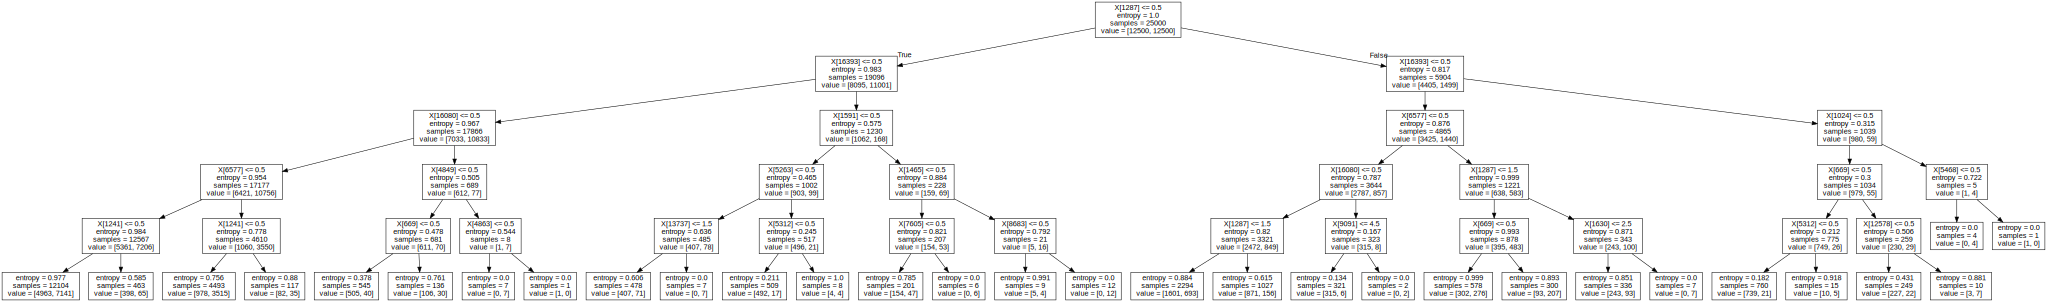

<Figure size 72x72 with 0 Axes>

In [39]:
plt.figure(figsize=(1,1))
dot_data=tree.export_graphviz(decision_tree_classifier,out_file=None)
graph=graphviz.Source(dot_data)
graph.render('df')
graph

## **Analyse Linéaire Discriminante**

> **Entrainnement du modèle**

In [40]:
#réduisons la taille de nos données
df_trainingLDA = train_data.loc[7500:17499]
df_testingLDA = test_data.loc[7500:17499]
trainingLDA = df_trainingLDA.copy()
testingLDA = df_testingLDA.copy()
y_trainingLDA = trainingLDA['sentiment'].values
y_testingLDA = testingLDA['sentiment'].values
trainingLDA.drop(['sentiment'], axis=1, inplace=True)
testingLDA.drop(['sentiment'], axis=1, inplace=True)

X_train_LDA = trainingLDA
X_test_LDA = testingLDA
Y_train_LDA = y_trainingLDA
Y_test_LDA = y_testingLDA



X_train_review_bow_LDA = vect.fit_transform(X_train_LDA['preprocessed_tokens'])
X_test_review_bow_LDA = vect.transform(X_test_LDA['preprocessed_tokens'])

LDA_classifier = LinearDiscriminantAnalysis()
LDA_classifier.fit(X_train_review_bow_LDA.toarray(), Y_train_LDA)

LinearDiscriminantAnalysis()

> **Evaluation du modèle et resultats**

In [41]:
Y_predicted_LDA = LDA_classifier.predict(X_test_review_bow_LDA.toarray())
print('Taux de prediction: ', accuracy_score(Y_test_LDA, Y_predicted_LDA))

Taux de prediction:  0.5641


## **SVM**

> **Entrainnement du modèle**

In [42]:
# Nous allons travailler sur les mêmes données que LDA

SVM_classifier = LinearSVC(class_weight='balanced', random_state=3, loss="hinge", fit_intercept=False)
SVM_classifier.fit(X_train_review_bow_LDA.toarray(), Y_train_LDA)


LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=3)

> **Evaluation du modèle et resultats**

In [43]:
Y_predicted_SVM=SVM_classifier.predict(X_test_review_bow_LDA.toarray())
print('Taux de prediction:',accuracy_score(Y_test_LDA, Y_predicted_SVM))

Taux de prediction: 0.8326
